In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("/Users/wilsonforero/Downloads/Prueba.xlsx")

In [3]:
df.head()

,id,created_at,text
0,AntanasMockus,2020-08-06 16:57:49,"Hoy, en el cumpleaños de Bogotá. Hacemos esta ..."
1,AntanasMockus,2020-07-21 23:08:14,@ClaudiaLopez @petrogustavo @EnriquePenalosa ¡...
2,AntanasMockus,2020-07-21 23:06:20,Aún en las diferencias podemos encontrar coinc...
3,AntanasMockus,2020-07-14 00:04:15,#EnVivo | A esta hora intervenimos en foro vir...
4,AntanasMockus,2020-06-28 03:24:04,"¡ANTANAS MOCKUS, conciencia moral y cívica de ..."


In [4]:
df.shape

(6395, 3)

In [34]:
col = ['id', 'text']
df= df[col]
df= df[pd.notnull(df['text'])]

In [35]:
df.columns=['Product', 'Consumer_complaint']

In [36]:
df['category_id'] = df['Product'].factorize()[0]

In [8]:
cat_id_df = df[["Product", "category_id"]].drop_duplicates().sort_values('category_id')

In [37]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [38]:
df.head()

,Product,Consumer_complaint,category_id
0,AntanasMockus,"Hoy, en el cumpleaños de Bogotá. Hacemos esta ...",0
1,AntanasMockus,@ClaudiaLopez @petrogustavo @EnriquePenalosa ¡...,0
2,AntanasMockus,Aún en las diferencias podemos encontrar coinc...,0
3,AntanasMockus,#EnVivo | A esta hora intervenimos en foro vir...,0
4,AntanasMockus,"¡ANTANAS MOCKUS, conciencia moral y cívica de ...",0


In [39]:
import matplotlib.pyplot as plt

In [40]:
fig = plt.figure(figsize= (8,6))

<Figure size 576x432 with 0 Axes>

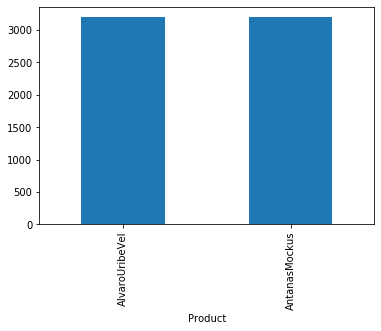

In [41]:
df.groupby('Product').Consumer_complaint.count().plot.bar(ylim=0)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [60]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wilsonforero/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:
stop_words=[word.decode('utf-8') for word in stopwords.words('spanish')]

NameError: name 'stopwords' is not defined

In [61]:
from nltk.corpus import stopwords
final_stopwords_list = stopwords.words('spanish') 

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=final_stopwords_list)
features = tfidf.fit_transform(df.Consumer_complaint).toarray()
labels = df.category_id
features.shape

(6395, 4325)

In [63]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'AlvaroUribeVel':
  . Most correlated unigrams:
. mockusalsenado
. antanasmockus
  . Most correlated bigrams:
. antanasmockus https
. aquí https
# 'AntanasMockus':
  . Most correlated unigrams:
. mockusalsenado
. antanasmockus
  . Most correlated bigrams:
. antanasmockus https
. aquí https


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [71]:

print(clf.predict(count_vect.transform(["Con mi fórmula a la cámara por Bogotá @KMiranda111 recorriendo y construyendo confianza con los ciudadanos. Los dos tenemos una apuesta y es trabajar en el  Congreso de la República para que la vida de los Colombianos sea sagrada. #MockusSenado1 https://t.co/8DwcmDlcKO"])))

['AntanasMockus']


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

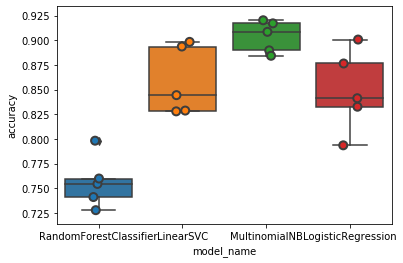

In [73]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [74]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.858640
LogisticRegression        0.848944
MultinomialNB             0.903987
RandomForestClassifier    0.756372
Name: accuracy, dtype: float64

In [75]:
from sklearn.model_selection import train_test_split

model =MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

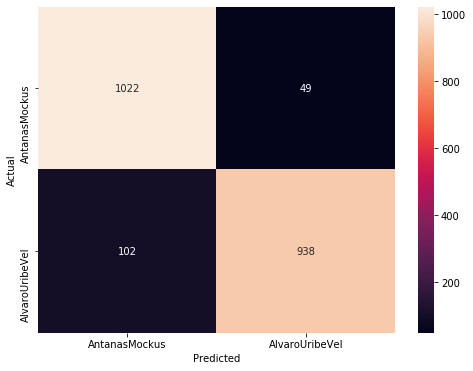

In [76]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [80]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint']])
      print('')

'AlvaroUribeVel' predicted as 'AntanasMockus' : 102 examples.


,Product,Consumer_complaint
6204,AlvaroUribeVel,Felices 245 años a mi TITIRIBI https://t.co/Ia...
4436,AlvaroUribeVel,Aprobamos en la #PlenariaVirtual de @SenadoGov...
4304,AlvaroUribeVel,https://t.co/iRujViI4by
3733,AlvaroUribeVel,"Trabajar, destrabar y avanzar / Opinión de la ..."
4506,AlvaroUribeVel,Hoy domingo a las 6 pm@ https://t.co/mftrLEDwUt
...,...,...
3638,AlvaroUribeVel,La Alcaldesa @ClaudiaLopez acusa de EXTORSIONI...
5607,AlvaroUribeVel,https://t.co/n2A4rJN3vj
5428,AlvaroUribeVel,https://t.co/Xqp4NysV5K
5169,AlvaroUribeVel,https://t.co/Ch1ZTt0xEZ



'AntanasMockus' predicted as 'AlvaroUribeVel' : 49 examples.


,Product,Consumer_complaint
634,AntanasMockus,Hoy los partidos que nos declaramos en oposici...
2278,AntanasMockus,Sigue en FACE LIVE la entrevista de los jóvene...
2518,AntanasMockus,Desde que Fanny Mikey y Ramiro Osorio fundaron...
202,AntanasMockus,¡Sumemos capacidades! https://t.co/eKcZ06R4wL
456,AntanasMockus,Quero agradecer al expresidente de la Corte Co...
1281,AntanasMockus,Invitados a conectarse con el #FacebookLiveET ...
495,AntanasMockus,"Felipe López, fundador de @RevistaSemana, me a..."
519,AntanasMockus,Prohibición de pólvora en Colombia supera su p...
2899,AntanasMockus,Hicimos plantón en la DIAN porque deja sin flu...
29,AntanasMockus,"En entrevista con #Semana, @AntanasMockus aseg..."


In [81]:
model.fit(features, labels)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [100]:
texts = ["Comunidad informa:La destrucción de laboratorios es un éxito del Gbno, sería mayor con la oferta de recompensas para denunciar otros laboratorios y caletas de dinero",
         "Valoremos los apoyos económicos y sociales que el Gbno Duque ha dado a las comunidades indígenas a pesar de la herencia económica y de la pandemia;"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Comunidad informa:La destrucción de laboratorios es un éxito del Gbno, sería mayor con la oferta de recompensas para denunciar otros laboratorios y caletas de dinero"
  - Predicted as: 'AlvaroUribeVel'

"Valoremos los apoyos económicos y sociales que el Gbno Duque ha dado a las comunidades indígenas a pesar de la herencia económica y de la pandemia;"
  - Predicted as: 'AlvaroUribeVel'



In [ ]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

In [17]:
features = tfidf.fit_transform(df.Consumer_complaint).toarray()

In [18]:
labels = df.category_id
features.shape

(2114, 6081)

In [90]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'AlvaroUribeVel':
  . Most correlated unigrams:
. mockusalsenado
. antanasmockus
  . Most correlated bigrams:
. antanasmockus https
. aquí https
# 'AntanasMockus':
  . Most correlated unigrams:
. mockusalsenado
. antanasmockus
  . Most correlated bigrams:
. antanasmockus https
. aquí https


In [91]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint'], df['Product'], random_state= 0)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [92]:
count_vect = CountVectorizer()

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer

In [94]:
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [95]:
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train_tfidf, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [4796, 4284]

In [48]:
print(clf.predict(count_vect.transform(['I have outdated information on my credit repor'])))

['Credit reporting']


In [90]:
y_pred = clf.predict(count_vect.transform(X_test))

In [91]:
from sklearn import metrics

In [92]:
print(metrics.classification_report(y_test,y_pred, labels= df.Product, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.70      0.87      0.77        91
                                                               Consumer Loan       0.36      0.43      0.39        21
                                                             Debt collection       0.70      0.87      0.77        91
                                                                    Mortgage       0.86      0.69      0.76       124
                                                                 Credit card       0.86      0.69      0.76       124
                                                     Other financial service       0.86      0.89      0.88       113
                                                     Bank account or service       0.86      0.89      0.88       113
                                                       

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1537: UserWarning: labels size, 2114, does not match size of target_names, 16
  .format(len(labels), len(target_names))
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
